In [1]:
import os
import cv2
import pandas as pd
import numpy as np 

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from tqdm.auto import tqdm


2024-06-08 16:52:30.340074: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-08 16:52:30.340193: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-08 16:52:30.481550: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
data_dir = '/kaggle/input/plantvillage-dataset/color'
image_size = 128
batch_size = 64
learn_rate = 0.01
epochs = 30

In [3]:
def read_img(image_data):
    image = cv2.imread(image_data)

    if image is None:
        raise ValueError("Could not read the image data.")

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (image_size, image_size))
    image = np.array(image, dtype=np.float32) / 255.0  # Normalize the image
    
    return image


def load_image_features(csv):
    df = pd.read_csv(csv)

    image_feats = df["image"]
    labels = df["emotion_labels"]

    return image_feats, labels


def image_data_csv(images, labels):

    data_for_df = {"image": images, "labels": labels}

    feature_df = pd.DataFrame(data_for_df)
    feature_df.to_csv('plant_disease.csv', index=False)

    print("Image data csv creation complete")

    return feature_df

In [4]:
# def get_image_files_and_labels(dir):
#     for folder, _, filenames in tqdm(os.walk(dir)):
#         for file in filenames:
#             file_path = os.path.join(folder, file)

#             label = folder.split('/')[5]
#             yield (file_path, label)

# file_paths, labels = zip(*get_image_files_and_labels(data_dir))

In [5]:
# data_df = image_data_csv(file_paths, labels)

In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(image_size, image_size),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(image_size, image_size),
  batch_size=batch_size)

Found 54305 files belonging to 38 classes.
Using 43444 files for training.
Found 54305 files belonging to 38 classes.
Using 10861 files for validation.


In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [8]:
# %%time

# normalization_layer = layers.Rescaling(1./255)
# normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

In [9]:
model = models.Sequential([
  layers.Rescaling(1./255, input_shape=(image_size, image_size, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(38, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:18: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 38)             │         9,766 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,204,614 (8.41 MB)

 Trainable params: 2,204,614 (8.41 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
%%time

epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10


2024-06-08 16:54:30.575429: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 32768: 3.40757, expected 2.65303
2024-06-08 16:54:30.575493: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 32769: 5.59344, expected 4.8389
2024-06-08 16:54:30.575502: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 32770: 3.89742, expected 3.14289
2024-06-08 16:54:30.575510: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 32771: 4.98111, expected 4.22658
2024-06-08 16:54:30.575518: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 32772: 4.53194, expected 3.7774
2024-06-08 16:54:30.575526: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 32773: 3.83744, expected 3.0829
2024-06-08 16:54:30.575534: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 32774: 4.4349, expected 3.68036
2024-06-08 16:54:30.575541: E e

 18/679 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.0982 - loss: 3.5909

I0000 00:00:1717865674.516947      75 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


276/679 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.3789 - loss: 2.3246

2024-06-08 16:54:37.529358: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.19741, expected 2.52428
2024-06-08 16:54:37.529413: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 4.72158, expected 4.04844
2024-06-08 16:54:37.529422: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 5.1767, expected 4.50356
2024-06-08 16:54:37.529430: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 3.97451, expected 3.30138
2024-06-08 16:54:37.529438: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 4.04906, expected 3.37592
2024-06-08 16:54:37.529446: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 4.7563, expected 4.08317
2024-06-08 16:54:37.529454: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 3.22555, expected 2.55241
2024-06-08 16:54:37.529462: E external/local_xla/xla/serv

675/679 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5226 - loss: 1.7335

2024-06-08 16:54:58.509156: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 2.80036, expected 2.23264
2024-06-08 16:54:58.509220: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 3.82728, expected 3.25956
2024-06-08 16:54:58.509236: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 3.96518, expected 3.39745
2024-06-08 16:54:58.509253: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 3.59902, expected 3.03129
2024-06-08 16:54:58.509266: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 3.13087, expected 2.56315
2024-06-08 16:54:58.509276: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 3.74997, expected 3.18225
2024-06-08 16:54:58.509288: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 3.23727, expected 2.66954
2024-06-08 16:54:58.509299: E external/local_xla/xla/se

679/679 ━━━━━━━━━━━━━━━━━━━━ 97s 37ms/step - accuracy: 0.5237 - loss: 1.7290 - val_accuracy: 0.7709 - val_loss: 0.7688
Epoch 2/10
679/679 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.8368 - loss: 0.5321 - val_accuracy: 0.8222 - val_loss: 0.6064
Epoch 3/10
679/679 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.8759 - loss: 0.4055 - val_accuracy: 0.8745 - val_loss: 0.4890
Epoch 4/10
679/679 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.9045 - loss: 0.3273 - val_accuracy: 0.8827 - val_loss: 0.4692
Epoch 5/10
679/679 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.9072 - loss: 0.3655 - val_accuracy: 0.8404 - val_loss: 0.6376
Epoch 6/10
679/679 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.9030 - loss: 0.4022 - val_accuracy: 0.8582 - val_loss: 0.7629
Epoch 7/10
679/679 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.9158 - loss: 0.3957 - val_accuracy: 0.8523 - val_loss: 0.9706
Epoch 8/10
679/679 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.8960 - loss: 0.5529 - val_accuracy: 0.84

Text(0.5, 1.0, 'Training and Validation Accuracy')

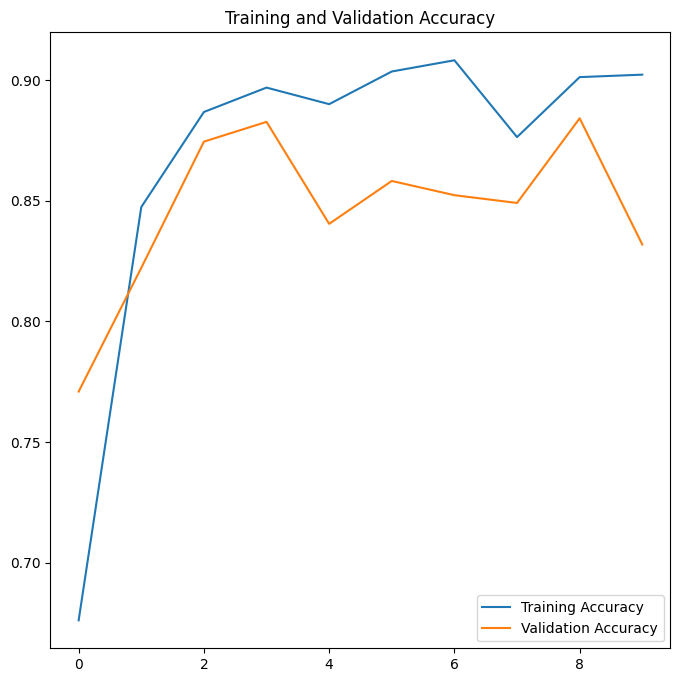

In [11]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

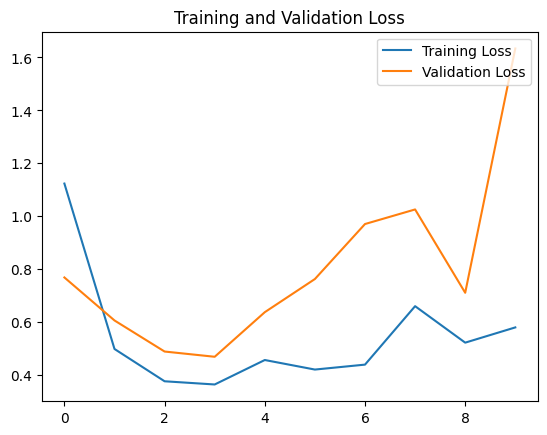

In [12]:

plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [13]:
model.save('tf_plant_disease_classifier.h5')

In [14]:
model.save('tf_plant_disease_classifier.keras')

In [15]:
print('Model training done... :)')

Model training done... :)
